<a href="https://colab.research.google.com/github/Taeu/FPO/blob/master/MIS_FULL_MONTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import urllib.request
import json
import pandas as pd
from bs4 import BeautifulSoup
import urllib
from urllib import request
import re
import numpy as np
import datetime
client_id = 'haQoQuQqDY8FwcshDiBY'
client_secret = ###
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!pip install finance-datareader

In [0]:
file_path = 'gdrive/My Drive/Colab Notebooks/kospi200_구성종목_주가_시가총액등'
file_name1 = 'kospi200_pdf_comp_20140101_20190931.xlsx'
file_name2 = 'kospi200_pdf_mkt_cap_201401_201909.xlsx'
file_name3 = 'kospi200_pdf_mkt_weight_201401_201909.xlsx'
kp200 = pd.read_excel(file_path+'/'+file_name1)
kp200_codes_list = kp200[:200].code
len(kp200_codes_list)
kp200_codes_list = kp200_codes_list.tolist()
kp200_names_list =kp200[:200].name.tolist()
kp_informations = pd.read_excel(file_path+'/'+'상장법인목록.xlsx')
#kp_informations.head(3)
kp_company_name_list = kp_informations['회사명'].tolist()
kp200  = []
for a in kp_company_name_list:
  if a in kp200_names_list:
    kp200.append(a)
len(kp200)

156

# 1번째 crowling test

In [0]:
def get_trend(body):
    url = "https://openapi.naver.com/v1/datalab/search"

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))

    return json.loads(response.read().decode('utf-8'))

print(len(kp_informations))
kp_informations_names = kp_informations.회사명.values.tolist()
idx = 0
drop_idx = []
i = 0
for name in kp_informations_names:
  if name not in kp200_names_list:
    drop_idx.append(i)
  i+=1
print(len(drop_idx))
kp200_inform = kp_informations.drop(drop_idx)
len(kp200_inform)

# 자동화를 위해, 그리고 같은 스케일을 가져오기 위해 하나씩 분석
from tqdm import tqdm
from datetime import datetime
names = kp200_inform.회사명.values
body_dict = {
    "startDate": "2017-01-01",
    "endDate": "2019-08-30",
    "timeUnit": "month",
}

for idx in tqdm(range(len(names))): # names
  name = names[idx]
  body_dict['keywordGroups'] = [{'groupName': name,'keywords':[name]}]
  body= json.dumps(body_dict)
  result = get_trend(body)
  
  if idx == 0 :
    data = result['results'][0]['data']
    time = np.array([datetime.strptime(i['period'],'%Y-%m-%d') for i in data])
    value = np.array([i['ratio'] for i in data])
    data = pd.DataFrame({'Time':time, idx : value})
  elif idx >= 1 : 
    data1 = result['results'][0]['data']
    time = np.array([datetime.strptime(i['period'],'%Y-%m-%d') for i in data1])
    value = np.array([i['ratio'] for i in data1])
    data1 = pd.DataFrame({'Time':time, idx : value})
    data = pd.merge(data,data1,on = ['Time'], sort= False)

  0%|          | 0/156 [00:00<?, ?it/s]

2323
2167


100%|██████████| 156/156 [01:58<00:00,  1.34it/s]


# From Now on let's data analysis from different Time Series

In [0]:
data_new = pd.read_csv(file_path+'/'+"kp200_trend_ts_month2.csv", index_col=0)
data_new.head(3)

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,2017-01-01,43.72161,19.74505,17.66914,32.85988,63.86691,37.47653,28.87101,31.93815,78.53634,49.83815,39.94744,42.91416,51.02294,24.40373,8.39446,70.93588,15.31347,64.07475,21.71775,49.43882,35.39637,85.77449,81.97265,27.60246,9.76038,26.86905,15.02446,41.08940,54.83203,97.95099,84.18119,66.19779,43.60207,70.92457,31.73296,49.75161,38.06789,14.24580,61.89031,...,5.54726,40.69591,31.59377,29.43351,39.38257,13.89004,2.94492,68.45954,38.37247,26.41657,28.71880,96.86986,100.00000,42.20552,44.71925,34.17128,63.36743,100.00000,25.28285,31.48395,26.14671,35.78170,61.45965,65.93993,54.26127,97.92900,5.64161,5.69028,37.81547,25.56566,48.13649,78.09778,36.78169,26.59406,42.73682,23.55416,48.72385,66.23435,2.36899,33.65981
1,2017-02-01,53.56684,37.10157,19.44558,33.28598,86.54984,38.62657,31.64756,31.90171,67.51832,47.86242,41.22553,34.12447,56.01109,27.51968,11.25255,53.64130,22.08802,78.32162,15.60033,51.63127,29.71001,84.08165,79.22083,31.51241,10.92724,40.13374,14.48588,39.29315,61.10914,100.00000,75.18661,68.16328,45.79270,75.75690,41.15021,51.08634,43.68390,15.53373,55.99218,...,6.28368,58.58699,32.77358,28.27607,41.41515,12.49316,2.90744,76.14196,47.62116,23.84440,26.48603,95.49774,89.88970,47.67705,16.25300,38.76634,65.08098,76.93098,21.96788,32.57432,25.62505,28.38331,52.76965,65.08923,50.55845,63.39207,5.98034,5.85112,38.60165,25.08017,54.18564,69.96069,28.68658,27.47765,41.34119,21.85170,48.90291,63.55181,2.72440,34.29173
2,2017-03-01,38.36064,38.13322,21.65651,38.50578,100.00000,42.75800,14.91797,36.69373,95.29140,49.21031,44.48684,36.96195,100.00000,36.49394,9.58220,52.44176,24.09486,71.53579,13.43246,54.77552,39.71363,91.50881,88.16072,32.98712,11.00333,45.78933,17.27775,48.14206,88.16579,90.06956,80.88003,85.26528,49.07005,64.89841,52.28400,63.12177,57.67597,20.66730,63.00819,...,6.87462,100.00000,42.56029,32.14764,56.87115,16.38484,3.85143,73.90433,47.62987,32.83884,29.83730,100.00000,82.77965,77.15629,21.35118,60.76497,71.43222,79.70994,26.58172,56.07623,28.60060,32.22285,33.30367,57.91892,53.19246,83.48408,6.41734,5.92488,58.25733,36.44916,59.44895,100.00000,28.68055,30.06872,68.76814,22.40738,63.11107,66.66638,2.37305,26.61997


# Change rate 활용

In [0]:
data_new_change_rate = pd.DataFrame()
data_new_change_rate['Time'] = data_new['Time'][1:]
for i in range(156):
  trend_indexs = data_new[str(i)].values.tolist()
  changes = []
  for j in range(1,len(trend_indexs)):
    changes.append(trend_indexs[j]/trend_indexs[j-1] - 1)
  data_new_change_rate[str(i)] = changes

In [0]:
df_ch = data_new_change_rate.drop(['Time'],axis=1)
df_ch.shape
df_ch.values.shape # (242, 156)

df_ch_np = df_ch.to_numpy()
df_ch_np = df_ch_np.T
df_ch_np.shape # (156, 242)

(156, 31)

In [0]:
def cos_matrix_multiplication(matrix, vector):
    """
    Calculating pairwise cosine distance using matrix vector multiplication.
    """
    dotted = matrix.dot(vector)
    matrix_norms = np.linalg.norm(matrix, axis=1)
    vector_norm = np.linalg.norm(vector)
    matrix_vector_norms = np.multiply(matrix_norms, vector_norm)
    neighbors = np.divide(dotted, matrix_vector_norms)
    return neighbors

In [0]:
from tqdm import tqdm
wl = []
for i in tqdm(range(len(df_ch_np)),mininterval = 3):
    nearest = list(cos_matrix_multiplication(df_ch_np, df_ch_np[i]).argsort()[-11:-1][::-1])
    li = []
    for x in nearest:
        li.append(x)
    wl.append(li)
wl =  np.asarray(wl)
print(wl.shape)
#np.save(directory+'article_similarity_recent_t',wl)

100%|██████████| 156/156 [00:00<00:00, 7499.27it/s]

(156, 10)


In [0]:
for i in range(156):
  print('company name : ',names[i],end="'s ")
  print('most similarly company are :', end = ' ')
  for j in wl[i]:
    print(names[j], end= ' ')
  print()

In [0]:
# Let's do the clustering for Stock Portfolio

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets.samples_generator import make_blobs

In [0]:
df_ch_np.shape

(156, 31)

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20)
kmeans.fit(df_ch_np)
y_kmeans = kmeans.predict(df_ch_np)

In [0]:
y_kmeans

array([19,  7, 17, 19,  7, 19,  7,  7,  7,  7, 19,  7, 19,  7,  7,  7, 19,
        7, 10,  7, 19,  7,  7,  7, 15, 19, 16, 19, 19,  7,  7, 19,  7,  7,
        7, 19,  7,  9, 19,  7,  6, 18, 19, 12, 19, 19, 19,  7,  1, 12,  7,
        7, 12,  7, 19,  7,  7, 11,  7,  1, 19,  7,  7, 19, 19,  7, 17, 19,
        7,  7, 17,  7,  7, 19, 19, 19,  7,  7,  7,  7,  7,  7,  7,  7,  4,
        7, 19,  1, 19, 12,  7,  7, 14,  7,  7,  7, 12,  7,  7,  7, 19, 19,
       19,  7, 19, 12,  7,  7, 13, 19,  7,  7,  7, 19,  7,  7,  1, 19,  1,
       19, 19,  1,  2,  7,  7, 19,  7,  7,  7,  7,  0, 19, 19,  7,  0,  7,
       19,  7,  7,  7,  7,  7,  8,  3, 19, 12,  7, 19,  9,  7,  7,  7,  7,
        7,  5,  7], dtype=int32)

In [0]:
li_cl=[]
for i in range(20):
  li_cl.append(0)
for i in y_kmeans:
  li_cl[i] += 1
li_cl

[2, 6, 1, 1, 1, 1, 1, 81, 1, 2, 1, 1, 7, 1, 1, 1, 1, 3, 1, 42]

In [0]:
# optimization
import FinanceDataReader as fdr
kodex_df = fdr.DataReader('069500', '2019-09-01', '2019-11-01')

In [0]:
kodex_close = kodex_df.Close.tolist()
kodex_return = []
for i in range(len(kodex_close)):
  kodex_return.append(kodex_close[i]/kodex_close[0])

In [0]:
kp_informations_names = kp_informations.회사명.values.tolist()
idx = 0
drop_idx = []
i = 0
for name in kp_informations_names:
  if name not in kp200_names_list:
    drop_idx.append(i)
  i+=1
print(len(drop_idx))
kp200_inform = kp_informations.drop(drop_idx)
len(kp200_inform)

# 자동화를 위해, 그리고 같은 스케일을 가져오기 위해 하나씩 분석
from tqdm import tqdm
from datetime import datetime
names = kp200_inform.회사명.values

2167


In [0]:
names_list = names.tolist()
#y_kmeans
codes_list = []
for name in names_list:
  for i in range(len(kp200_names_list)):
    if kp200_names_list[i] == name:
      codes_list.append(kp200_codes_list[i][1:])
      break
len(codes_list)

156

In [0]:
len(names_list)

156

In [0]:
kospi_156 = pd.DataFrame()
for code_idx in tqdm(range(len(codes_list))):
  close_list = fdr.DataReader(codes_list[code_idx], '2019-09-01', '2019-11-01').Close.tolist()
  # 여기서 작업을 하는게 더 좋겠지??
  if(len(close_list)==len(kodex_return)):
    kospi_156[codes_list[code_idx]] = close_list
  else:
    print(names_list[code_idx],'is shorter than kodex200')
    close_list = []
    for i in range(len(kodex_return)):
      close_list.append(1.0)
    kospi_156[codes_list[code_idx]] = close_list

In [0]:
b = kospi_156.columns
for i in range(len(b)):
  kospi_156[b[i]] = kospi_156[b[i]].astype('float32')

In [0]:
#data.to_excel("kp200_trend_timeseries.xlsx")
#data.to_csv(file_path+'/'+"kp200_trend_ts_month3.csv", mode='w') # 다시 불러올때 Time 형으로 변환, 굳이 필요한가 싶지만..

#data_new = pd.read_csv(file_path+'/'+"kp200_trend_ts_month3.csv", index_col=0)
#data_new.head(3)

kospi_156.to_csv(file_path + '/' + "kp156_1.csv",mode='w')

In [0]:
new_kospi_156 = pd.read_csv(file_path + '/' + "kp156_1.csv")
new_kospi_156 = new_kospi_156.drop(['Unnamed: 0'],axis=1)
new_kospi_156.head()

,003030,003300,006120,007340,004990,001800,005740,004150,000830,060980,044820,079980,007070,078520,047810,139480,020150,011210,128940,033920,103130,032830,088350,120110,115390,052690,003600,000080,108670,105630,035420,105560,104700,103140,011070,032640,097950,097230,096770,029780,...,000720,010620,006360,006400,009150,005180,003920,006260,001740,004430,000430,003570,004370,001630,000880,000670,002240,002350,000210,001120,003240,002020,005930,007570,009830,006380,000140,004800,001040,000150,003520,002270,001680,003550,000640,001440,000070,003490,000100,000120
0,51100.0,47700.0,22350.0,30750.0,33650.0,15750.0,10700.0,4340.0,1.0,42900.0,13400.0,6290.0,39200.0,10100.0,39400.0,113500.0,42450.0,44400.0,284000.0,9000.0,914.0,68300.0,2460.0,39800.0,12250.0,18050.0,1.0,23700.0,60700.0,18700.0,150000.0,39600.0,4935.0,22150.0,99100.0,13200.0,226000.0,4840.0,165500.0,33400.0,...,41150.0,41650.0,31900.0,246000.0,90000.0,57300.0,511000.0,45450.0,5370.0,18700.0,3750.0,6360.0,234500.0,87800.0,24450.0,574000.0,23400.0,9440.0,96500.0,17150.0,1066000.0,15250.0,43800.0,20400.0,17200.0,3515.0,10800.0,87100.0,81300.0,79167.0,4545.0,444000.0,21750.0,71200.0,87700.0,593.0,59900.0,22300.0,226000.0,146000.0
1,51300.0,48400.0,22800.0,30700.0,33800.0,16300.0,10750.0,4330.0,1.0,43050.0,13700.0,6350.0,40100.0,11250.0,39900.0,114000.0,41800.0,44000.0,282000.0,8850.0,914.0,67600.0,2445.0,40150.0,12700.0,17950.0,1.0,24250.0,60700.0,18350.0,150500.0,39450.0,4940.0,22000.0,99900.0,13200.0,224500.0,4825.0,162500.0,33150.0,...,41150.0,41650.0,31900.0,246500.0,90400.0,57000.0,507000.0,45850.0,5450.0,18750.0,3820.0,6280.0,241500.0,88500.0,24500.0,583000.0,23450.0,9320.0,96500.0,16800.0,1122000.0,15450.0,43250.0,20600.0,17350.0,3540.0,11100.0,86600.0,80600.0,79167.0,4690.0,448500.0,21750.0,70900.0,88200.0,595.0,60500.0,22200.0,226000.0,142000.0
2,51600.0,48050.0,23050.0,30650.0,34050.0,16400.0,10750.0,4290.0,1.0,43600.0,13700.0,6310.0,41200.0,11300.0,41750.0,114000.0,42150.0,46750.0,285000.0,8950.0,914.0,67700.0,2445.0,40900.0,12950.0,18300.0,1.0,25550.0,61600.0,18650.0,151000.0,40050.0,4900.0,22150.0,104500.0,13350.0,226500.0,4780.0,161500.0,33500.0,...,41450.0,41850.0,31750.0,246000.0,92700.0,56700.0,512000.0,45550.0,5460.0,18650.0,3855.0,6370.0,251500.0,96000.0,24500.0,580000.0,23200.0,9340.0,95200.0,16950.0,1114000.0,15600.0,44100.0,21000.0,17400.0,3530.0,11200.0,87100.0,81400.0,79955.0,4700.0,448500.0,22150.0,71700.0,88700.0,591.0,62000.0,22350.0,228000.0,142500.0
3,51400.0,48000.0,22900.0,30500.0,33950.0,16150.0,10950.0,4285.0,1.0,43100.0,13600.0,6320.0,40300.0,11150.0,41050.0,112500.0,41750.0,48450.0,280500.0,9010.0,914.0,69000.0,2445.0,40950.0,12700.0,18150.0,1.0,25900.0,61400.0,18550.0,147000.0,39750.0,4895.0,22400.0,105000.0,13250.0,229500.0,4760.0,164000.0,32950.0,...,41950.0,41950.0,32300.0,244000.0,98200.0,56200.0,504000.0,46200.0,5410.0,18950.0,3855.0,6220.0,244500.0,94000.0,24300.0,577000.0,23100.0,9240.0,95800.0,17400.0,1104000.0,15400.0,45700.0,20800.0,17900.0,3580.0,11150.0,87800.0,81600.0,79955.0,4655.0,442500.0,21850.0,71100.0,87300.0,585.0,61000.0,22500.0,227500.0,140000.0
4,50500.0,47900.0,22450.0,30750.0,33950.0,16050.0,10850.0,4335.0,1.0,42300.0,13550.0,6280.0,40900.0,11200.0,41600.0,112000.0,41950.0,48650.0,280500.0,8970.0,914.0,68200.0,2395.0,42100.0,12450.0,18000.0,1.0,25950.0,60100.0,19200.0,149500.0,40550.0,4890.0,22300.0,103000.0,13100.0,227500.0,4755.0,164500.0,33200.0,...,42400.0,42700.0,32050.0,244000.0,97200.0,56200.0,498500.0,46950.0,5310.0,18800.0,3830.0,6300.0,240000.0,92300.0,24300.0,575000.0,22650.0,9120.0,97100.0,17000.0,1095000.0,15900.0,46300.0,20800.0,17750.0,3570.0,11050.0,87700.0,80600.0,80349.0,4620.0,434500.0,21600.0,71900.0,86800.0,579.0,61200.0,22650.0,227500.0,136500.0


In [0]:
new_kospi_return = pd.DataFrame()
for i in range(len(codes_list)):
  
  k = new_kospi_156[codes_list[i]].tolist()
  k_return =[]
  for j in range(len(k)):
    k_return.append(k[j]/k[0])
  new_kospi_return[i] = k_return

In [0]:
cluster=[] 
cluster.append([0,1])
cluster.append([2,3,4,5,6,7,8,9,10])
cluster.append([11,13])
cluster.append([12])
cluster.append([14,15,16,17,18,19])

In [0]:
init_return = []
for i in range(41):
  init_return.append(0.0)
init_returns = []
for i in range(20):
  init_returns.append(init_return.copy())
#print(init_returns)
cluster_n = [0,0,0,0,0] + [0,0,0,0,0] + [0,0,0,0,0] + [0,0,0,0,0]
for i in range(len(y_kmeans)):
  current_return = new_kospi_return[i].tolist()
  #print(y_kmeans[i], current_return)
  for j in range(20):
    if y_kmeans[i] == j:
      for k in range(41):
        init_returns[j][k] = init_returns[j][k] + current_return[k]
      #print(j, init_returns[j])
      cluster_n[j] += 1
print(cluster_n)
print(init_returns)

for j in range(len(cluster_n)):
  for k in range(len(init_returns[j])):
    init_returns[j][k] /= cluster_n[j]

print(init_returns)

[2, 6, 1, 1, 1, 1, 1, 81, 1, 2, 1, 1, 7, 1, 1, 1, 1, 3, 1, 42]
[[2.0, 2.002044989775051, 1.9885734871843777, 1.9866111446644839, 2.000082647255158, 2.0246500736408235, 2.0432202761265987, 2.059662841582165, 2.1142545323542814, 2.1183445119043833, 2.110026807378916, 2.0842853661379364, 2.107981817603865, 2.1008932261038176, 2.0894391642031427, 2.0504190639668565, 2.065990654502686, 2.0703561249033133, 2.1104400436547044, 2.0867160431037224, 2.026044481176558, 1.9991014759952108, 2.0022653824554713, 1.9919302372400054, 1.919804613412166, 1.9495809360331435, 2.034875022516079, 2.030785042965977, 2.039047649321339, 2.020560094090721, 2.0246500736408235, 2.0163323691153563, 2.0379838308062346, 1.9627769477732921, 1.975157082763809, 1.9432255740275703, 1.9442342943725697, 1.9205653919916927, 1.9238119457071108, 1.9143753244964345, 1.925691640971847], [6.0, 6.027614926017226, 6.028993202704429, 6.055454784275139, 6.054993541088288, 6.009250147741708, 6.13054228087613, 6.254504592757302, 6.414

In [0]:
cluster_return = pd.DataFrame()
time_list = []
for j in range(len(init_returns[0])):
  time_list.append(j)
for i in range(len(init_returns)):
  cluster_return[i] = init_returns[i]
cluster_return['Time'] = time_list
cluster_return['kodex'] = kodex_return
cluster_return.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Time,kodex
36,0.972117,0.979994,0.948141,0.967853,0.996503,0.975664,0.925054,1.020248,1.226852,0.956095,1.156690,0.873529,1.013604,0.971631,0.967005,0.946939,1.0,1.051678,1.182510,1.060341,36,1.076194
37,0.960283,0.978275,0.940313,0.970149,0.986014,0.975664,0.916488,1.018474,1.212963,0.946849,1.179577,0.876471,1.012235,0.967376,0.953046,0.971429,1.0,1.040621,1.224335,1.057634,37,1.073874
38,0.961906,0.970087,0.922701,0.960964,0.991259,0.977876,0.903640,1.010417,1.254630,0.938984,1.181338,0.879412,1.002000,0.960284,0.994924,0.963265,1.0,1.031138,1.399240,1.048513,38,1.065751
39,0.957188,0.970812,0.920744,0.949483,0.987762,0.993363,0.903640,1.013837,1.245370,0.944033,1.174296,0.897059,1.000582,0.953191,0.983503,0.963265,1.0,1.019617,1.460076,1.049733,39,1.069812
40,0.962846,0.964184,0.913894,0.926521,0.993007,0.971239,0.898287,1.016602,1.282407,0.944782,1.176056,0.879412,1.014938,0.956028,1.003807,0.955102,1.0,0.997942,1.490494,1.047873,40,1.077935


In [0]:
import matplotlib.pyplot as plt
#'롯데제과', '오리온', '크라운제과', '한솔제지','삼성물산'
cluster_return.plot(x='Time',figsize = (15,7))
fig = plt.gcf()
#fig.savefig(file_path+'/'+'output5_change_rate.png')

In [0]:
cl1 = [8,10,18]
cl2 = [19]
cl3 = [7,12,14]
cl4 = [0,1,2,3,4,5,6]
cl5 = [9,11,13,15,17]

In [0]:
for i in range(156):
  if y_kmeans[i] in cl1:
    print(i,'th. This is hot : ',names_list[i])

18 th. This is hot :  한미약품
41 th. This is hot :  아모레퍼시픽
142 th. This is hot :  하이트진로홀딩스


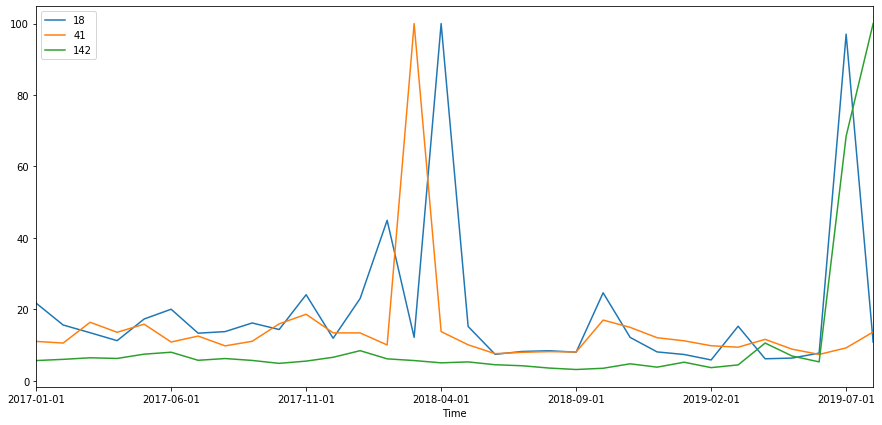

In [0]:
data_new_hot = data_new[['Time', '18','41','142']]
data_new_hot.plot(x='Time',figsize = (15,7))
fig = plt.gcf()
#fig.savefig(file_path+'/'+'output5_change_rate.png')

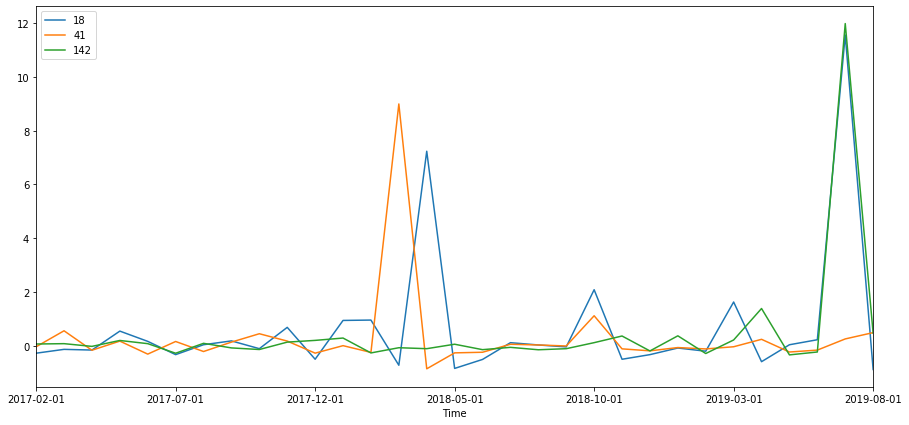

In [0]:
data_new_hot = data_new_change_rate[['Time', '18','41','142']]
data_new_hot.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

In [0]:
for i in range(156):
  if y_kmeans[i] in cl2:
    print(i,'th. This is fine : ',names_list[i])

0 th. This is fine :  세아제강
3 th. This is fine :  동아타이어
5 th. This is fine :  오리온
10 th. This is fine :  코스맥스
12 th. This is fine :  GS리테일
16 th. This is fine :  일진머티리얼즈
20 th. This is fine :  웅진에너지
25 th. This is fine :  한전기술
27 th. This is fine :  하이트진로
28 th. This is fine :  LG하우시스
31 th. This is fine :  KB금융
35 th. This is fine :  LG유플러스
38 th. This is fine :  SK이노베이션
42 th. This is fine :  롯데쇼핑
44 th. This is fine :  하나금융지주
45 th. This is fine :  금호타이어
46 th. This is fine :  유니드
54 th. This is fine :  SBS
60 th. This is fine :  LG전자
63 th. This is fine :  신한지주
64 th. This is fine :  LG생활건강
67 th. This is fine :  대우조선해양
73 th. This is fine :  제일기획
74 th. This is fine :  SKC
75 th. This is fine :  SK하이닉스
86 th. This is fine :  삼성중공업
88 th. This is fine :  화신
100 th. This is fine :  대덕전자
101 th. This is fine :  에스엘
102 th. This is fine :  한국쉘석유
104 th. This is fine :  한솔테크닉스
109 th. This is fine :  세방전지
113 th. This is fine :  코리아써키트
117 th. This is fine :  현대미포조선
119 th. This is fine

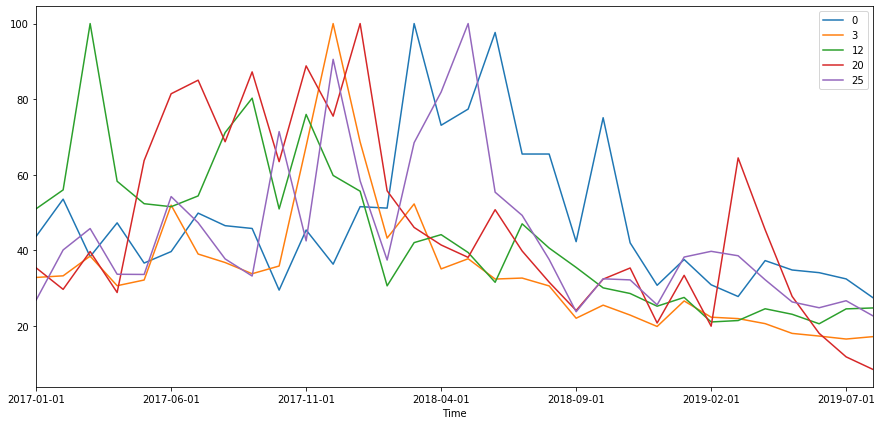

In [0]:
data_new_hot = data_new[['Time', '0','3','12','20','25']]
data_new_hot.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

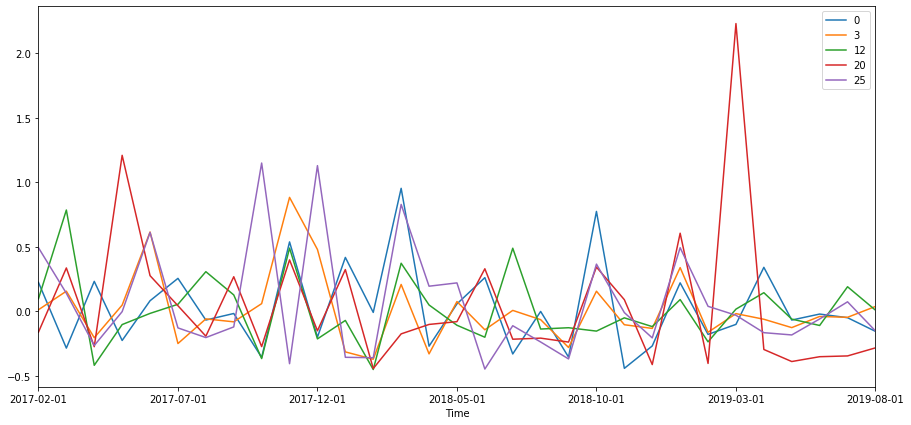

In [0]:
data_new_hot = data_new_change_rate[['Time', '0','3','12','20','25']]
data_new_hot.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

In [0]:
for i in range(156):
  if y_kmeans[i] in cl3:
    print(i,'th. This is fine : ',names_list[i])

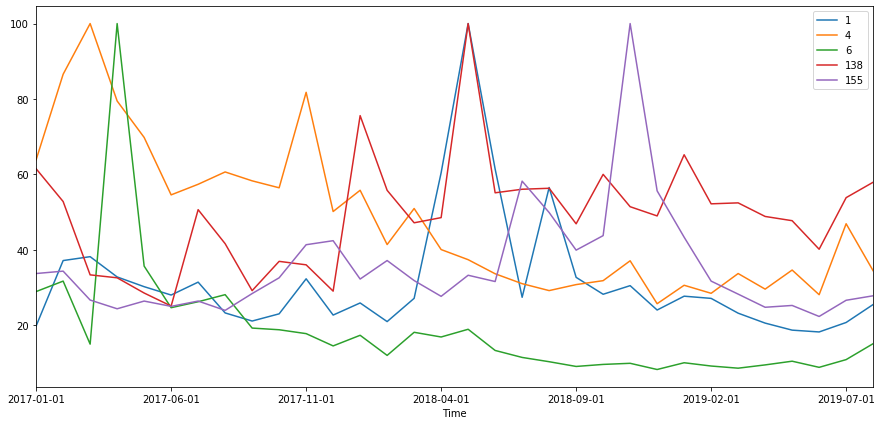

In [0]:
data_new_hot = data_new[['Time', '1','4','6','138','155']]
data_new_hot.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

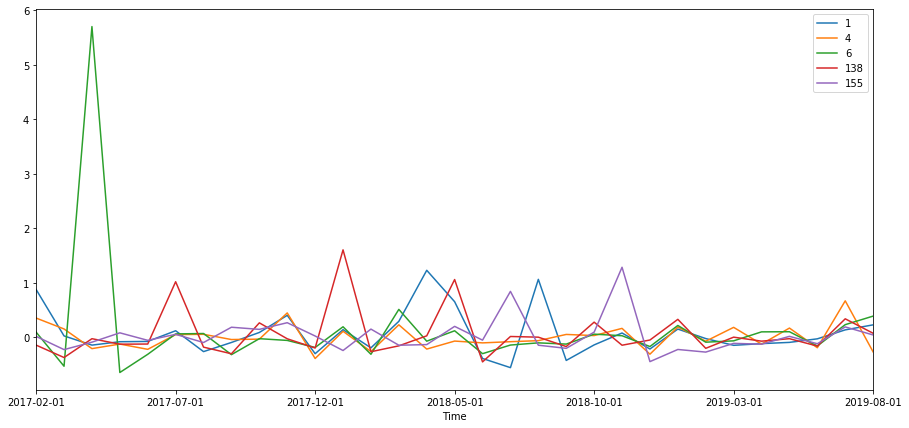

In [0]:
data_new_hot = data_new_change_rate[['Time', '1','4','6','138','155']]
data_new_hot.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

In [0]:
for i in range(156):
  if y_kmeans[i] in [1]:
    print(i,'th. This is not fine : ',names_list[i])

48 th. This is not fine :  LG디스플레이
59 th. This is not fine :  세종공업
87 th. This is not fine :  모토닉
116 th. This is not fine :  현대건설
118 th. This is not fine :  GS건설
121 th. This is not fine :  빙그레


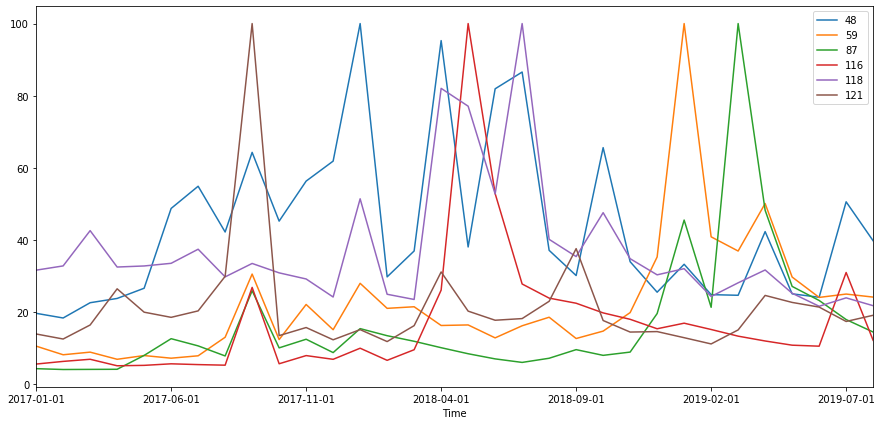

In [0]:
data_new_bad = data_new[['Time', '48','59','87','116','118','121']]
data_new_bad.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

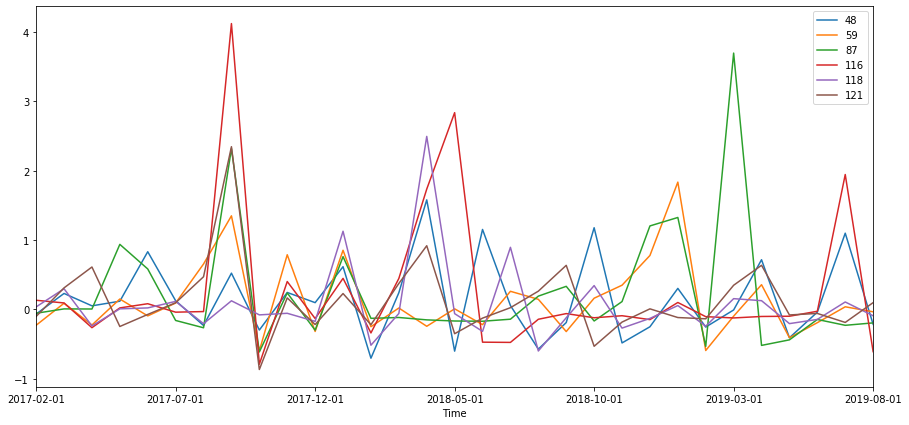

In [0]:
data_new_bad = data_new_change_rate[['Time', '48','59','87','116','118','121']]
data_new_bad.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

In [0]:
data_new_bad = data_new[['Time', '48','59','87','116','118','121']]
data_new_bad.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

In [0]:
for i in range(156):
  if y_kmeans[i] in cl4:
    print(i,'th. This is not fine : ',names_list[i])

40 th. This is not fine :  후성
48 th. This is not fine :  LG디스플레이
59 th. This is not fine :  세종공업
84 th. This is not fine :  오뚜기
87 th. This is not fine :  모토닉
116 th. This is not fine :  현대건설
118 th. This is not fine :  GS건설
121 th. This is not fine :  빙그레
122 th. This is not fine :  남양유업
130 th. This is not fine :  한화
134 th. This is not fine :  대림산업
143 th. This is not fine :  효성
154 th. This is not fine :  유한양행


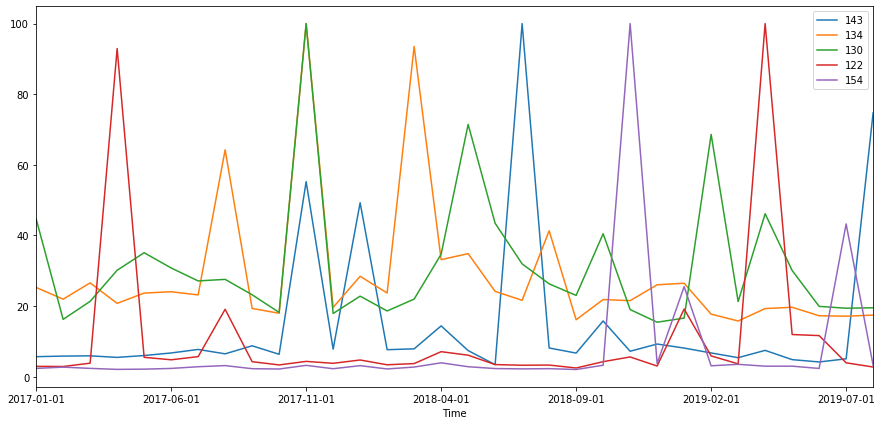

In [0]:
data_new_bad = data_new[['Time', '143','134','130','122','154']]
data_new_bad.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

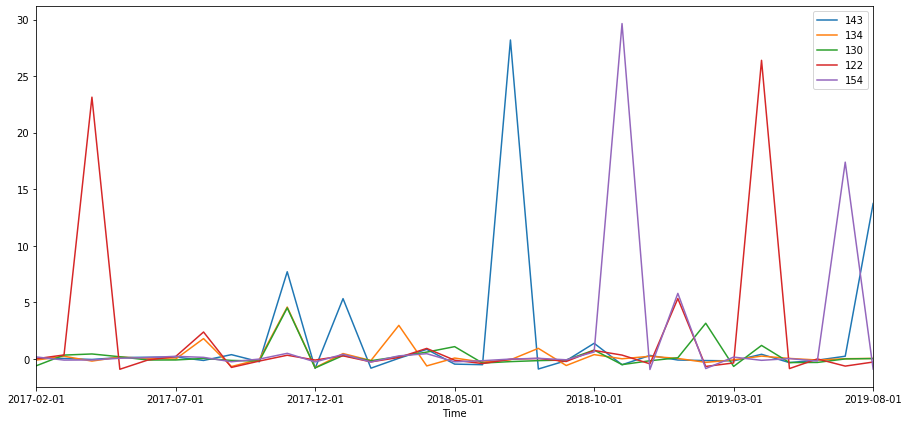

In [0]:
data_new_bad = data_new_change_rate[['Time', '143','134','130','122','154']]
data_new_bad.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

In [0]:
for i in range(156):
  if y_kmeans[i] in cl5:
    print(i,'th. This is not fine : ',names_list[i])

2 th. This is not fine :  SK케미칼
24 th. This is not fine :  락앤락
37 th. This is not fine :  한진중공업
57 th. This is not fine :  대웅제약
66 th. This is not fine :  대우건설
70 th. This is not fine :  두산중공업
108 th. This is not fine :  삼성증권
148 th. This is not fine :  대상


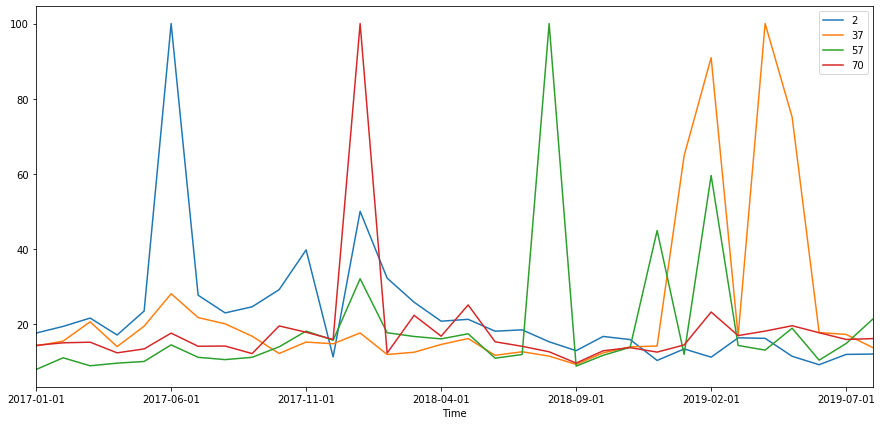

In [0]:
data_new_bad = data_new[['Time', '2','37','57','70']]
data_new_bad.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

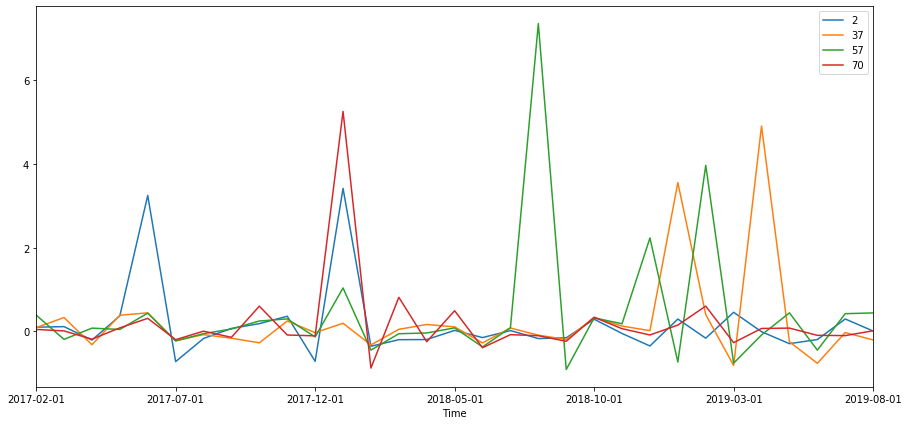

In [0]:
data_new_bad = data_new_change_rate[['Time', '2','37','57','70']]
data_new_bad.plot(x='Time',figsize = (15,7))
fig = plt.gcf()

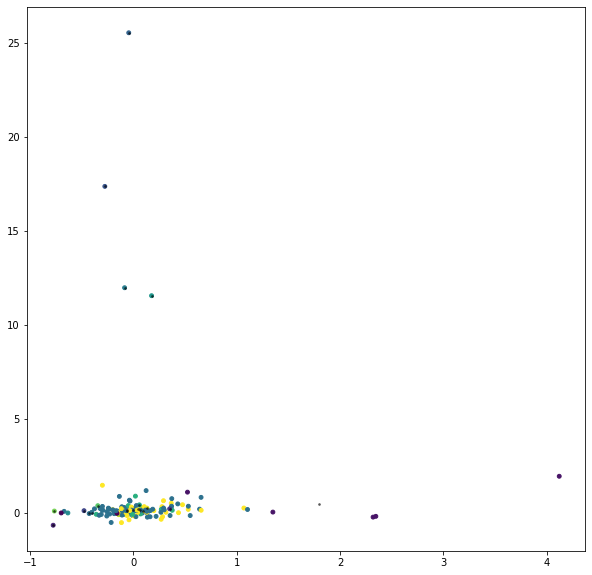

In [0]:
fig = plt.subplots(figsize=(10,10))
plt.scatter(df_ch_np[:, 7], df_ch_np[:,29], c=y_kmeans, s=15, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 7], centers[:,29], c='black', s=3, alpha=0.5);

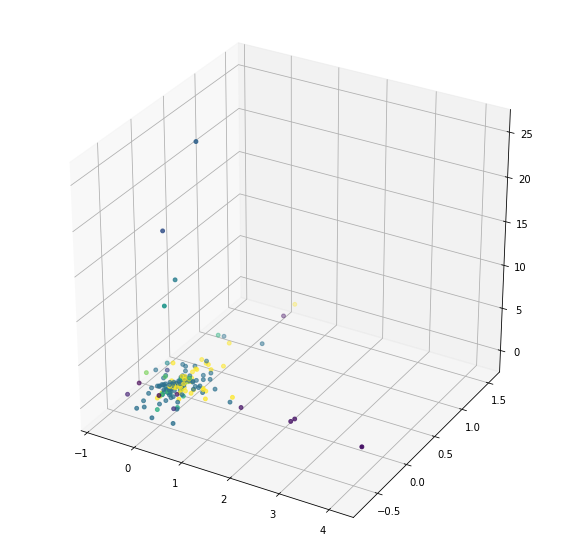

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_ch_np[:,7], df_ch_np[:,16],df_ch_np[:,29], c=y_kmeans, s=15, cmap='viridis')

#centers = kmeans.cluster_centers_
#ax.scatter(centers[:, 3], centers[:, 7],df_ch_np[:,80], c='black', s=70, alpha=0.5);

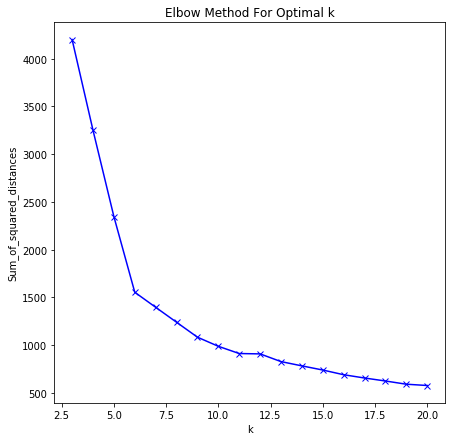

In [0]:
Sum_of_squared_distances = []
K = range(3,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ch_np)
    Sum_of_squared_distances.append(km.inertia_)

K = range(3,21)
fig = plt.figure(figsize=(7,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')

plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
# optimizing

In [0]:
init_return = []
for i in range(41):
  init_return.append(0.0)
init_returns = []
for i in range(5):
  init_returns.append(init_return.copy())
#print(init_returns)
cluster_n = [0,0,0,0,0]
for i in range(len(y_kmeans)):
  current_return = new_kospi_return[i].tolist()
  #print(y_kmeans[i], current_return)
  for j in range(20):
    if y_kmeans[i] in cl1:
      for k in range(41):
        init_returns[0][k] = init_returns[0][k] + current_return[k]
      cluster_n[0] += 1
    elif y_kmeans[i] in cl2:
      for k in range(41):
        init_returns[1][k] = init_returns[1][k] + current_return[k]
      cluster_n[1] += 1
    elif y_kmeans[i] in cl3:
      for k in range(41):
        init_returns[2][k] = init_returns[2][k] + current_return[k]
      cluster_n[2] += 1
    elif y_kmeans[i] in cl4:
      for k in range(41):
        init_returns[3][k] = init_returns[3][k] + current_return[k]
      cluster_n[3] += 1
    else :
      for k in range(41):
        init_returns[4][k] = init_returns[4][k] + current_return[k]
      cluster_n[4] += 1
print(cluster_n)
print(init_returns)

for j in range(len(cluster_n)):
  for k in range(len(init_returns[j])):
    init_returns[j][k] /= cluster_n[j]

print(init_returns)

[60, 840, 1780, 260, 180]
[[60.0, 61.935623032661546, 61.9518476865984, 61.84653619506073, 60.976940363487735, 61.231075369269504, 61.17369404428262, 62.3024876480401, 63.1826850413848, 63.0377738902079, 63.3951030503539, 63.26338682708838, 63.26550416426169, 62.062782270301106, 62.44863349934839, 61.462802303186734, 61.4254736984078, 62.256674818662766, 61.546181751826275, 62.790144613633025, 62.804896552955185, 62.1584591339049, 62.340951780249235, 63.447491029829145, 62.766586138433226, 63.098884108764686, 63.68687409628876, 63.50487235481602, 64.99522979306626, 64.99140172679499, 65.5842015903334, 65.86516281182371, 67.40548345700174, 70.12889475991282, 70.6270689904814, 71.77738802906163, 71.32102996800691, 72.33750057024302, 76.70414403049764, 77.59484381291264, 78.97916084027044], [840.0, 843.9466036684147, 852.1193069216795, 851.9262183947709, 849.9861463538516, 851.5105222294363, 860.3519234117585, 868.7181742304756, 878.8224635754822, 879.0889662743739, 879.151614572613, 878.

In [0]:
cluster_return = pd.DataFrame()
time_list = []
for j in range(len(init_returns[0])):
  time_list.append(j)
for i in range(len(init_returns)):
  
  cluster_return[i] = init_returns[i]
cluster_return['Time'] = time_list
cluster_return['kodex'] = kodex_return
#cluster_return.tail()

In [0]:
portfolio_By_Clustering = pd.DataFrame()
portfolio_By_Clustering['Time'] = time_list
portfolio_By_Clustering['Median'] = cluster_return[0] * 0.2 + cluster_return[1] * 0.5 + cluster_return[2] * 0.3
portfolio_By_Clustering['HighRisk'] = cluster_return[0] * 0.33 + cluster_return[1] * 0.33 + cluster_return[2] * 0.33
portfolio_By_Clustering['LowRisk'] = cluster_return[0] * 0.15 + cluster_return[1] * 0.35 + cluster_return[2] * 0.35 + cluster_return[3] * 0.08 + cluster_return[4] * 0.07
portfolio_By_Clustering['kodex'] = kodex_return

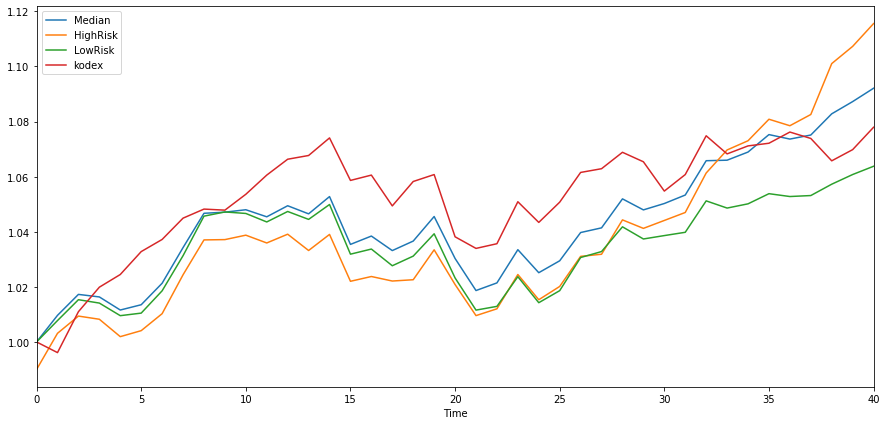

In [0]:
import matplotlib.pyplot as plt
portfolio_By_Clustering.plot(x='Time',figsize = (15,7))
fig = plt.gcf()
#fig.savefig(file_path+'/'+'output5_change_rate.png')

In [0]:
# [0,1], [2~10], [11,13], [12], [14~19]

In [0]:
# https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [0]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ch_np)
    Sum_of_squared_distances.append(km.inertia_)

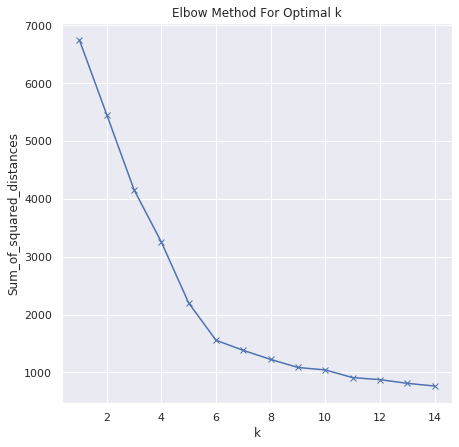

In [0]:
K = range(1,15)
fig = plt.figure(figsize=(7,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')

plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
#https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
from sklearn.metrics import silhouette_score

sil = [] 
for k in range(2, 14+1):
  kmeans = KMeans(n_clusters = k).fit(df_ch_np)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_ch_np, labels, metric = 'euclidean'))

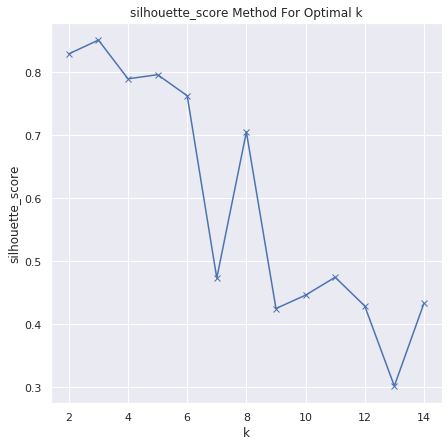

In [0]:
K = range(2,14+1)
fig = plt.figure(figsize=(7,7))
plt.plot(K, sil, 'bx-')

plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score Method For Optimal k')
plt.show()

In [0]:
df_ch = data_new.drop(['Time'],axis=1)
df_ch.shape
df_ch.values.shape # (242, 156)

df_ch_np = df_ch.to_numpy()
df_ch_np = df_ch_np.T
df_ch_np.shape # (156, 242)

(156, 6)

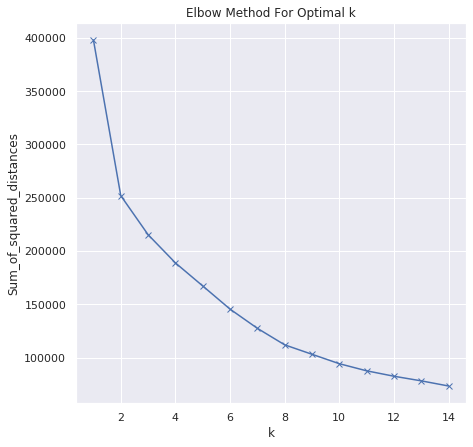

In [0]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ch_np)
    Sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=(7,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')

plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

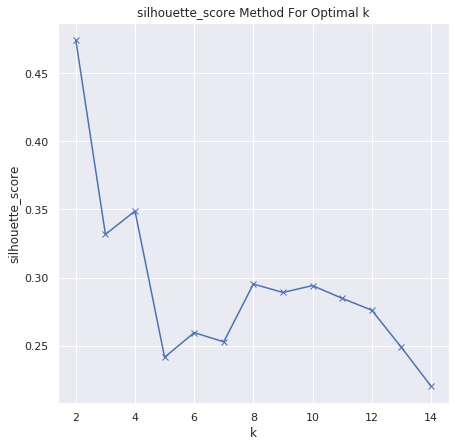

In [0]:
from sklearn.metrics import silhouette_score

sil = [] 
for k in range(2, 14+1):
  kmeans = KMeans(n_clusters = k).fit(df_ch_np)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_ch_np, labels, metric = 'euclidean'))

K = range(2,14+1)
fig = plt.figure(figsize=(7,7))
plt.plot(K, sil, 'bx-')

plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score Method For Optimal k')
plt.show()

In [0]:
# for the long time

In [0]:
def get_trend(body):
    url = "https://openapi.naver.com/v1/datalab/search"

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))

    return json.loads(response.read().decode('utf-8'))
print(len(kp_informations))
kp_informations_names = kp_informations.회사명.values.tolist()
idx = 0
drop_idx = []
i = 0
for name in kp_informations_names:
  if name not in kp200_names_list:
    drop_idx.append(i)
  i+=1
print(len(drop_idx))
kp200_inform = kp_informations.drop(drop_idx)
len(kp200_inform)

# 자동화를 위해, 그리고 같은 스케일을 가져오기 위해 하나씩 분석
from tqdm import tqdm
from datetime import datetime
names = kp200_inform.회사명.values
body_dict = {
    "startDate": "2016-01-01",
    "endDate": "2019-10-30",
    "timeUnit": "month",
}


for idx in tqdm(range(len(names))): # names
  name = names[idx]
  body_dict['keywordGroups'] = [{'groupName': name,'keywords':[name]}]
  body= json.dumps(body_dict)
  result = get_trend(body)
  
  if idx == 0 :
    data = result['results'][0]['data']
    time = np.array([datetime.strptime(i['period'],'%Y-%m-%d') for i in data])
    value = np.array([i['ratio'] for i in data])
    data = pd.DataFrame({'Time':time, idx : value})
  elif idx >= 1 : 
    data1 = result['results'][0]['data']
    time = np.array([datetime.strptime(i['period'],'%Y-%m-%d') for i in data1])
    value = np.array([i['ratio'] for i in data1])
    data1 = pd.DataFrame({'Time':time, idx : value})
    data = pd.merge(data,data1,on = ['Time'], sort= False)

  0%|          | 0/156 [00:00<?, ?it/s]

2323
2167


100%|██████████| 156/156 [01:57<00:00,  1.17it/s]


In [0]:
data.shape

(46, 157)

In [0]:
#data.to_excel("kp200_trend_timeseries.xlsx")
#data.to_csv(file_path+'/'+"kp200_trend_ts_month3.csv", mode='w') # 다시 불러올때 Time 형으로 변환, 굳이 필요한가 싶지만..

data_new = pd.read_csv(file_path+'/'+"kp200_trend_ts_month3.csv", index_col=0)
data_new.head(3)

data_new_change_rate = pd.DataFrame()
data_new_change_rate['Time'] = data_new['Time'][1:]
for i in range(156):
  trend_indexs = data_new[str(i)].values.tolist()
  changes = []
  for j in range(1,len(trend_indexs)):
    changes.append(trend_indexs[j]/trend_indexs[j-1] - 1)
  data_new_change_rate[str(i)] = changes

df_ch = data_new_change_rate.drop(['Time'],axis=1)
df_ch.shape
df_ch.values.shape # (242, 156)

df_ch_np = df_ch.to_numpy()
df_ch_np = df_ch_np.T
df_ch_np.shape # (156, 242)

(156, 45)

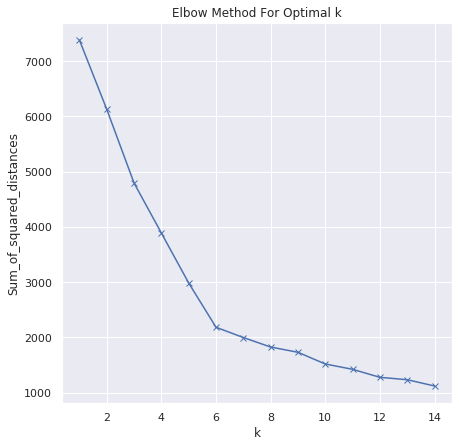

In [0]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ch_np)
    Sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=(7,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')

plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

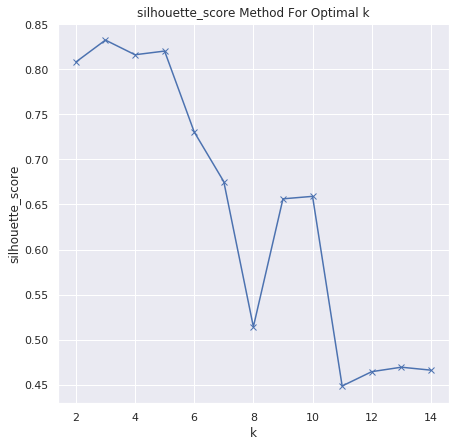

In [0]:
from sklearn.metrics import silhouette_score

sil = [] 
for k in range(2, 14+1):
  kmeans = KMeans(n_clusters = k).fit(df_ch_np)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_ch_np, labels, metric = 'euclidean'))

K = range(2,14+1)
fig = plt.figure(figsize=(7,7))
plt.plot(K, sil, 'bx-')

plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score Method For Optimal k')
plt.show()

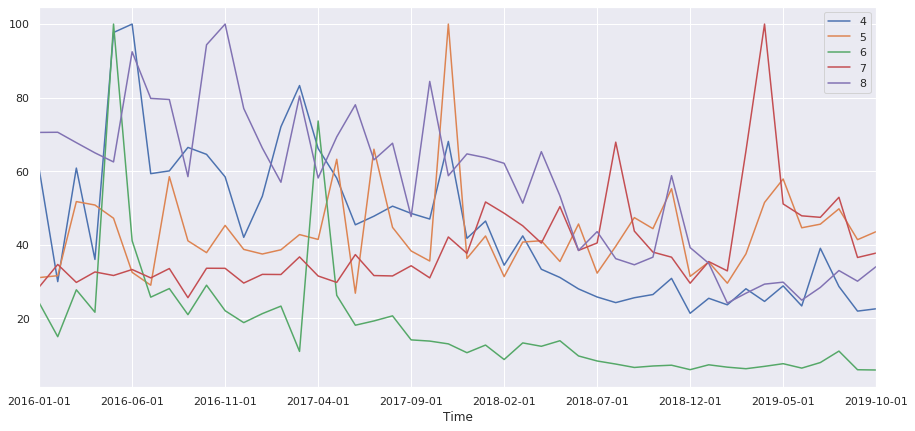

In [0]:
data_new_5 = data_new[['Time', '4','5','6','7','8']]
#'롯데제과', '오리온', '크라운제과', '한솔제지','삼성물산'
data_new_5.plot(x='Time',figsize = (15,7))
fig = plt.gcf()
fig.savefig(file_path+'/'+'output5.png')

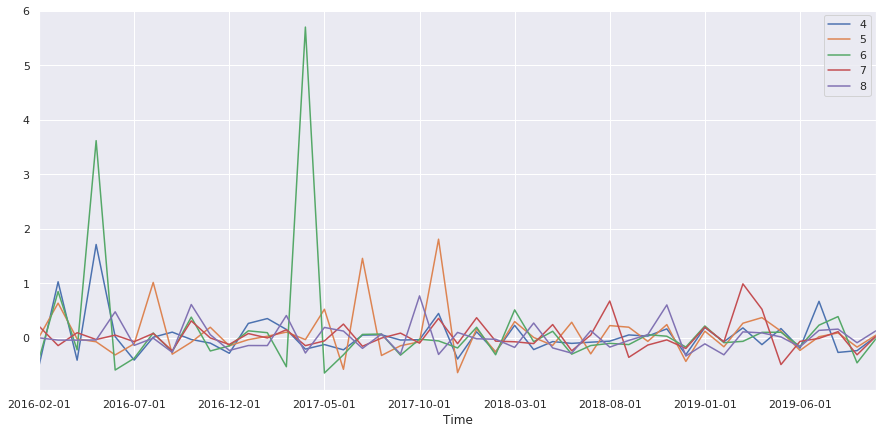

In [0]:
data_new_5 = data_new_change_rate[['Time', '4','5','6','7','8']]
#'롯데제과', '오리온', '크라운제과', '한솔제지','삼성물산'
data_new_5.plot(x='Time',figsize = (15,7))
fig = plt.gcf()
fig.savefig(file_path+'/'+'output5_change_rate.png')

In [0]:
from tqdm import tqdm
wl = []
for i in tqdm(range(len(df_ch_np)),mininterval = 3):
    nearest = list(cos_matrix_multiplication(df_ch_np, df_ch_np[i]).argsort()[-11:-1][::-1])
    li = []
    for x in nearest:
        li.append(x)
    wl.append(li)
wl =  np.asarray(wl)
print(wl.shape)
#np.save(directory+'article_similarity_recent_t',wl)

100%|██████████| 156/156 [00:00<00:00, 7042.35it/s]

(156, 10)


In [0]:
for i in range(156):
  print('company name : ',names[i],end="'s ")
  print('most similarly company are :', end = ' ')
  for j in wl[i]:
    print(names[j], end= ' ')
  print()

company name :  세아제강's most similarly company are : 고려제강 대림산업 세방전지 삼광글라스 이수화학 신도리코 하나금융지주 현대모비스 LG하우시스 아모레퍼시픽 
company name :  한일시멘트's most similarly company are : 삼성증권 SK텔레콤 무림P&P 아이에스동서 LS산전 남해화학 대웅제약 이수화학 호텔신라 현대상선 
company name :  SK케미칼's most similarly company are : 두산중공업 대우건설 한국금융지주 S&T모티브 삼성전기 대한유화 OCI 동아쏘시오홀딩스 대원강업 SK하이닉스 
company name :  동아타이어's most similarly company are : NAVER 한국쉘석유 현대미포조선 고려제강 대림산업 금호타이어 한솔테크닉스 롯데쇼핑 현대제철 무림P&P 
company name :  롯데제과's most similarly company are : 한세실업 신도리코 삼성카드 롯데푸드 롯데쇼핑 LS산전 LS 에스원 만도 크라운제과 
company name :  오리온's most similarly company are : 대림산업 LS 일진머티리얼즈 오뚜기 롯데쇼핑 풍산 KPX케미칼 한화 한국금융지주 에스원 
company name :  크라운제과's most similarly company are : 남양유업 롯데제과 한세실업 동원F&B 빙그레 만도 엔씨소프트 두산 세아제강 삼성카드 
company name :  한솔제지's most similarly company are : 아이에스동서 휴켐스 웅진에너지 한국철강 모토닉 한국금융지주 세아베스틸 LG화학 넥센타이어 무림P&P 
company name :  삼성물산's most similarly company are : 에스엘 롯데케미칼 OCI 넥센타이어 휴켐스 NAVER 유한양행 코오롱 삼성생명 한전기술 
company name :  만도's most similarly company

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_ch_np)
y_kmeans = kmeans.predict(df_ch_np)

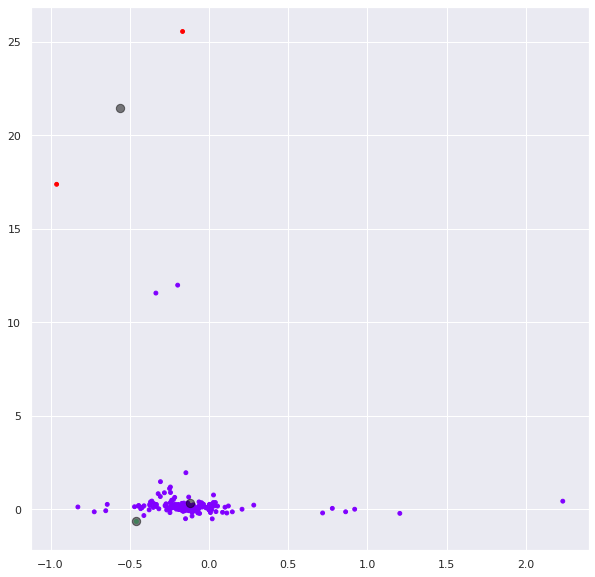

In [0]:
fig = plt.subplots(figsize=(10,10))
plt.scatter(df_ch_np[:, 34], df_ch_np[:, 41], c=y_kmeans, s=15, cmap='rainbow')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 34], centers[:, 41], c='black', s=70, alpha=0.5);

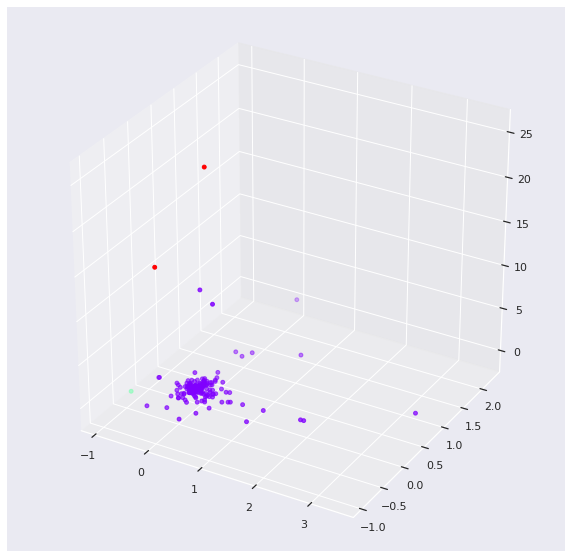

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_ch_np[:, 15], df_ch_np[:, 34],df_ch_np[:,41], c=y_kmeans, s=15, cmap='rainbow')

#centers = kmeans.cluster_centers_
#ax.scatter(centers[:, 3], centers[:, 7],df_ch_np[:,80], c='black', s=70, alpha=0.5);

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans.fit(df_ch_np)
y_kmeans = kmeans.predict(df_ch_np)

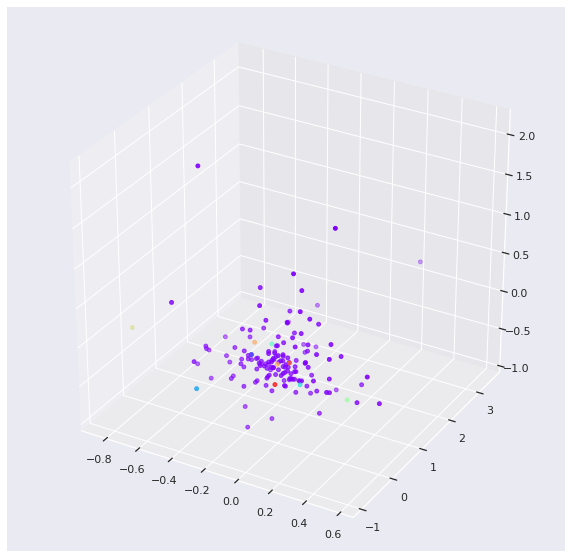

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_ch_np[:, 5], df_ch_np[:, 15],df_ch_np[:,20], c=y_kmeans, s=15, cmap='rainbow')

#centers = kmeans.cluster_centers_
#ax.scatter(centers[:, 3], centers[:, 7],df_ch_np[:,80], c='black', s=70, alpha=0.5);

Week

In [0]:
def get_trend(body):
    url = "https://openapi.naver.com/v1/datalab/search"

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))

    return json.loads(response.read().decode('utf-8'))
print(len(kp_informations))
kp_informations_names = kp_informations.회사명.values.tolist()
idx = 0
drop_idx = []
i = 0
for name in kp_informations_names:
  if name not in kp200_names_list:
    drop_idx.append(i)
  i+=1
print(len(drop_idx))
kp200_inform = kp_informations.drop(drop_idx)
len(kp200_inform)

# 자동화를 위해, 그리고 같은 스케일을 가져오기 위해 하나씩 분석
from tqdm import tqdm
from datetime import datetime
names = kp200_inform.회사명.values
body_dict = {
    "startDate": "2016-01-01",
    "endDate": "2019-10-30",
    "timeUnit": "week",
}


for idx in tqdm(range(len(names))): # names
  name = names[idx]
  body_dict['keywordGroups'] = [{'groupName': name,'keywords':[name]}]
  body= json.dumps(body_dict)
  result = get_trend(body)
  
  if idx == 0 :
    data = result['results'][0]['data']
    time = np.array([datetime.strptime(i['period'],'%Y-%m-%d') for i in data])
    value = np.array([i['ratio'] for i in data])
    data = pd.DataFrame({'Time':time, idx : value})
  elif idx >= 1 : 
    data1 = result['results'][0]['data']
    time = np.array([datetime.strptime(i['period'],'%Y-%m-%d') for i in data1])
    value = np.array([i['ratio'] for i in data1])
    data1 = pd.DataFrame({'Time':time, idx : value})
    data = pd.merge(data,data1,on = ['Time'], sort= False)

  0%|          | 0/156 [00:00<?, ?it/s]

2323
2167


100%|██████████| 156/156 [02:00<00:00,  1.32it/s]


In [0]:
#data.to_excel("kp200_trend_timeseries.xlsx")
data.to_csv(file_path+'/'+"kp200_trend_ts_week3.csv", mode='w') # 다시 불러올때 Time 형으로 변환, 굳이 필요한가 싶지만..

data_new = pd.read_csv(file_path+'/'+"kp200_trend_ts_week3.csv", index_col=0)
data_new.head(3)

data_new_change_rate = pd.DataFrame()
data_new_change_rate['Time'] = data_new['Time'][1:]
for i in range(156):
  trend_indexs = data_new[str(i)].values.tolist()
  changes = []
  for j in range(1,len(trend_indexs)):
    changes.append(trend_indexs[j]/trend_indexs[j-1] - 1)
  data_new_change_rate[str(i)] = changes

df_ch = data_new_change_rate.drop(['Time'],axis=1)
df_ch.shape
df_ch.values.shape 

df_ch_np = df_ch.to_numpy()
df_ch_np = df_ch_np.T
df_ch_np.shape 

(156, 200)

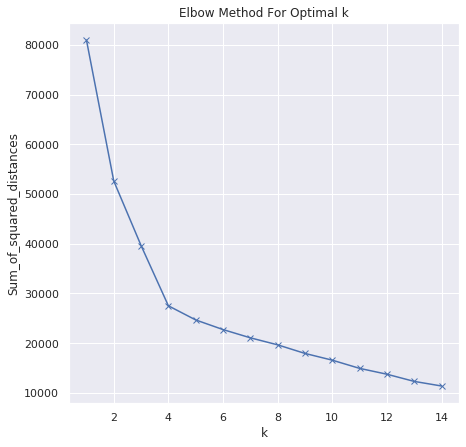

In [0]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ch_np)
    Sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=(7,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')

plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

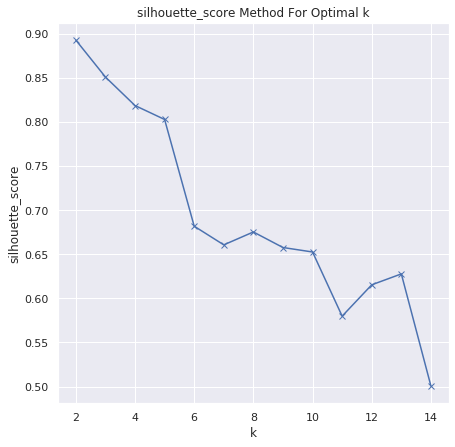

In [0]:
from sklearn.metrics import silhouette_score

sil = [] 
for k in range(2, 14+1):
  kmeans = KMeans(n_clusters = k).fit(df_ch_np)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_ch_np, labels, metric = 'euclidean'))

K = range(2,14+1)
fig = plt.figure(figsize=(7,7))
plt.plot(K, sil, 'bx-')

plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score Method For Optimal k')
plt.show()